# 0. Preparation (Data source, data type, order and libraries)

In [307]:
import pandas as pd
from sodapy import Socrata

client = Socrata("data.cms.gov", None)

# All results, returned as JSON from API / converted to Python list of dictionaries by sodapy.
results = client.get("s2uc-8wxp", limit=999999)

# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(results)

In [308]:
# A few other libraries
import matplotlib.ticker as ticker

In [309]:
# Assign the original data to a variable for future manipulation
df = results_df

In [310]:
# Adjust text styles
df["provider_name"] = df["provider_name"].str.title()
df["provider_city"] = df["provider_city"].str.title()

# Extract NY State data
mask_ny = df["provider_state"] == "NY"
df = df[mask_ny]

# Extract NYC data (NYC consists of 5 counties: Bronx, Kings/Brooklyn, New York/Manhattan, Queens, and Richmond/Staten Island)
mask_b = df["county"] == "Bronx"
mask_k = df["county"] == "Kings"
mask_n = df["county"] == "New York"
mask_q = df["county"] == "Queens"
mask_r = df["county"] == "Richmond"
df = df[mask_b | mask_k | mask_n | mask_q | mask_r]

# Convert week_ending's data type to datime
df["week_ending"] = df["week_ending"].astype("datetime64")

# Sort the data by time
df.sort_values(by = "week_ending", inplace = True)

##### Now we have the data of nursing homes NYC, sorted in the order of timeline

In [311]:
df

,week_ending,federal_provider_number,provider_name,provider_address,provider_city,provider_state,provider_zip_code,submitted_data,county,geolocation,...,has_facility_performed_staff_and_or_personnel_tests_since_last_report,tested_staff_and_or_personnel_with_new_signs_or_symptoms,tested_asymptomatic_staff_and_or_personnel_in_a_unit_or_section_after_a_new_case,tested_asymptomatic_staff_and_or_personnel_facility_wide_after_a_new_case,tested_asymptomatic_staff_and_or_personnel_without_known_exposure_as_surveillance,tested_another_subgroup_of_staff_and_or_personnel,number_of_ventilators_in,number_of_ventilators_in_1,any_current_supply_of,one_week_supply_of_ventilator
71,2020-05-24,335317,Park Terrace Care Center,59 20 VAN DOREN STREET,Corona,NY,11368,N,Queens,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
140355,2020-05-24,335131,"New Carlton Rehab And Nursing Center, L L C",405 CARLTON AVE,Brooklyn,NY,11238,Y,Kings,"{'type': 'Point', 'coordinates': [-73.971395, ...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
141709,2020-05-24,335545,King David Center For Nursing And Rehabilitation,2266 CROPSEY AVENUE,Brooklyn,NY,11214,Y,Kings,"{'type': 'Point', 'coordinates': [-73.998053, ...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
153974,2020-05-24,335737,"West Lawrence Care Center, L L C",1410 SEAGIRT BLVD,Far Rockaway,NY,11691,Y,Queens,"{'type': 'Point', 'coordinates': [-73.748745, ...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
137272,2020-05-24,335125,Spring Creek Rehabilitation & Nursing Care Center,660 LOUISIANA AVE,Brooklyn,NY,11239,Y,Kings,"{'type': 'Point', 'coordinates': [-73.884738, ...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145221,2020-09-06,335791,Queens Boulevard Extended Care Facility,61 11 QUEENS BOULEVARD,Woodside,NY,11377,Y,Queens,NaN,...,Y,N,N,N,Y,N,NaN,NaN,NaN,NaN
145202,2020-09-06,335780,Casa Promesa,308 EAST 175 STREET,Bronx,NY,10457,Y,Bronx,"{'type': 'Point', 'coordinates': [-73.904049, ...",...,Y,N,N,N,Y,N,NaN,NaN,NaN,NaN
137548,2020-09-06,335545,King David Center For Nursing And Rehabilitation,2266 CROPSEY AVENUE,Brooklyn,NY,11214,Y,Kings,"{'type': 'Point', 'coordinates': [-73.998053, ...",...,Y,N,N,Y,Y,N,NaN,NaN,NaN,NaN
137163,2020-09-06,335486,Pelham Parkway Nursing Ctr & Rehab Facility L L C,2401 LACONIA AVE,Bronx,NY,10469,Y,Bronx,"{'type': 'Point', 'coordinates': [-73.855917, ...",...,Y,N,N,N,Y,N,NaN,NaN,NaN,NaN


# 1. Overview of this piece of data
Since the main object of this project is to figure out the distribution of medical resources (equipments, professionals,etc) across those nursing homes in NYC, it is a good idea to first at the general distribution of nursing homes.

## a. Number of nursing homes in NYC

In [312]:
# Number of nursing homes
df["provider_name"].nunique()

171

##### There are 171 nursing homes on record.

## b. Number of nursing homes that submitted data

In [313]:
# Extract number of nursing homes that submitted data
mask1 = df["submitted_data"] == "Y"
data_submission = df[mask1].pivot_table(
    values = "submitted_data", 
    index = "week_ending", 
    aggfunc = "count"
)

# Convert it into percentages
data_submission["Percentage of Data Submission"] = data_submission["submitted_data"]/171

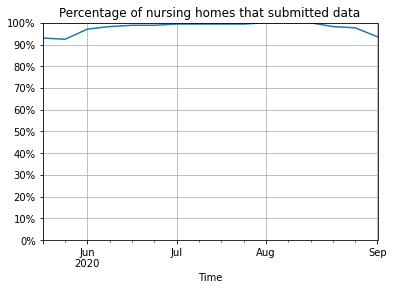

In [343]:
# Plot the change
data_submission["Percentage of Data Submission"].plot(
    title = "Percentage of nursing homes that submitted data", 
    xlabel = "Time", 
    ylim = (0, 1),
    yticks = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
    grid = True
).yaxis.set_major_formatter(ticker.PercentFormatter(xmax = 1))

##### So in summary, there are 171 nursing homes on record in NYC, and over 90% of them have been submitting data in the past few months. This value has been quite stable near 100% in the past few months, with minimum level of variation, and thus we can conclude that most of the nursing homes in NYC are quite active.

# 2. Medical supply sufficiency
One of the main concerns we have about nursing homes in NYC is whether they have sufficient supply of medical equipments. To figure this out, we need to look at whether they have at least one week supply of masks, eye protection, gowns, gloves and hand sanitizers.

## a. N95 masks supply

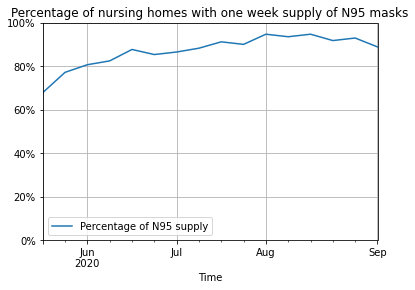

In [342]:
# Extract number of nursing homes with at least one week of N95 mask supply
mask2 = df["one_week_supply_of_n95_masks"] == "Y"
N95_supply = df[mask2].pivot_table(
    values = "one_week_supply_of_n95_masks", 
    index = "week_ending", 
    aggfunc = "count"
)

# Convert it into percentages
N95_supply["Percentage of N95 supply"] = N95_supply["one_week_supply_of_n95_masks"]/171
# Plot
N95_supply.plot(y = ["Percentage of N95 supply"],
                xlabel = "Time",
                ylim = (0, 1),
                title = "Percentage of nursing homes with one week supply of N95 masks",
                grid = True
).yaxis.set_major_formatter(ticker.PercentFormatter(xmax = 1))

##### The number of nursing homes with sufficient supply of N95 masks has been increasing in the past few months, and we can expect this trend to be continued/at least maintained in the following months.

## b. Surgical masks supply

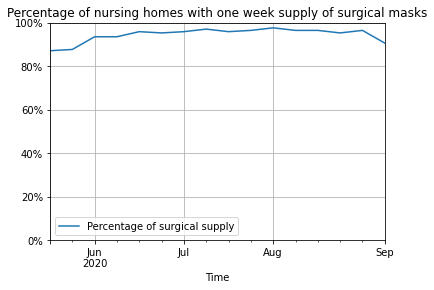

In [341]:
# Extract number of nursing homes with at least one week of surgical mask supply
mask3 = df["one_week_supply_of_surgical"] == "Y"
Surgical_supply = df[mask3].pivot_table(
    values = "one_week_supply_of_surgical", 
    index = "week_ending", 
    aggfunc = "count"
)

# Convert it into percentages
Surgical_supply["Percentage of surgical supply"] = Surgical_supply["one_week_supply_of_surgical"]/171
# Plot
Surgical_supply.plot(y = ["Percentage of surgical supply"],
                     xlabel = "Time",
                     ylim = (0, 1),
                     title = "Percentage of nursing homes with one week supply of surgical masks",
                     grid = True
).yaxis.set_major_formatter(ticker.PercentFormatter(xmax = 1))

## c. Eye protection supply

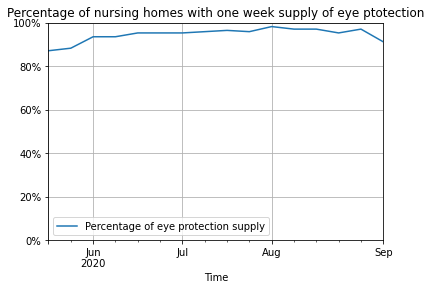

In [340]:
# Extract number of nursing homes with at least one week of eye protection supply
mask4 = df["one_week_supply_of_eye"] == "Y"
Eye_supply = df[mask4].pivot_table(
    values = "one_week_supply_of_eye", 
    index = "week_ending", 
    aggfunc = "count"
)

# Convert it into percentages
Eye_supply["Percentage of eye protection supply"] = Eye_supply["one_week_supply_of_eye"]/171
# Plot
Eye_supply.plot(y = ["Percentage of eye protection supply"],
                xlabel = "Time",
                ylim = (0, 1),
                title = "Percentage of nursing homes with one week supply of eye ptotection",
                grid = True
).yaxis.set_major_formatter(ticker.PercentFormatter(xmax = 1))

## d. Gown supply

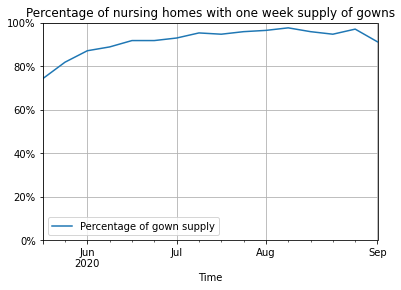

In [339]:
# Extract number of nursing homes with at least one week of gown supply
mask5 = df["one_week_supply_of_gowns"] == "Y"
Gown_supply = df[mask5].pivot_table(
    values = "one_week_supply_of_gowns", 
    index = "week_ending", 
    aggfunc = "count"
)

# Convert it into percentages
Gown_supply["Percentage of gown supply"] = Gown_supply["one_week_supply_of_gowns"]/171
# Plot
Gown_supply.plot(y = ["Percentage of gown supply"],
                 xlabel = "Time",
                 ylim = (0, 1),
                 title = "Percentage of nursing homes with one week supply of gowns",
                 grid = True
).yaxis.set_major_formatter(ticker.PercentFormatter(xmax = 1))

## e. Gloves supply

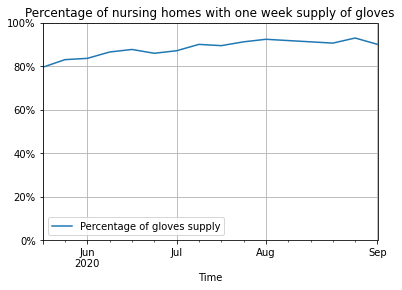

In [338]:
# Extract number of nursing homes with at least one week of gloves supply
mask6 = df["one_week_supply_of_gloves"] == "Y"
Gloves_supply = df[mask6].pivot_table(
    values = "one_week_supply_of_gloves", 
    index = "week_ending", 
    aggfunc = "count"
)

# Convert it into percentages
Gloves_supply["Percentage of gloves supply"] = Gloves_supply["one_week_supply_of_gloves"]/171
# Plot
Gloves_supply.plot(y = ["Percentage of gloves supply"],
                   xlabel = "Time",
                   ylim = (0, 1),
                   title = "Percentage of nursing homes with one week supply of gloves",
                   grid = True
).yaxis.set_major_formatter(ticker.PercentFormatter(xmax = 1))

## f. Hand sanitizer supply

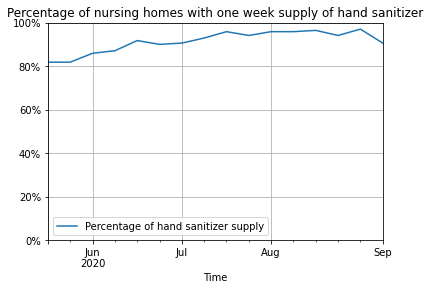

In [370]:
# Extract number of nursing homes with at least one week of hand sanitizer supply
mask7 = df["one_week_supply_of_hand"] == "Y"
HS_supply = df[mask7].pivot_table(
    values = "one_week_supply_of_hand", 
    index = "week_ending", 
    aggfunc = "count"
)

# Convert it into percentages
HS_supply["Percentage of hand sanitizer supply"] = HS_supply["one_week_supply_of_hand"]/171
# Plot
HS_supply.plot(y = ["Percentage of hand sanitizer supply"],
               xlabel = "Time",
               ylim = (0, 1),
               title = "Percentage of nursing homes with one week supply of hand sanitizer",
               grid = True
).yaxis.set_major_formatter(ticker.PercentFormatter(xmax = 1))

# 3. Staff protection problem

Total number of nursing home residents confirmed COVID-19.

<AxesSubplot:title={'center':'Total number of residents confirmed COVID-19'}, xlabel='Time'>

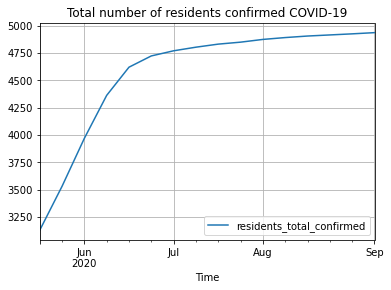

In [371]:
df["residents_total_confirmed"] = df["residents_total_confirmed"].fillna(0).astype(float)
total_confirmed_resident = df.pivot_table(values = "residents_total_confirmed", index = "week_ending", aggfunc = "sum")
total_confirmed_resident.plot(title = "Total number of residents confirmed COVID-19",
                     xlabel = "Time",
                     grid = True                
)

<AxesSubplot:title={'center':'Total number of staffs confirmed COVID-19'}, xlabel='Time'>

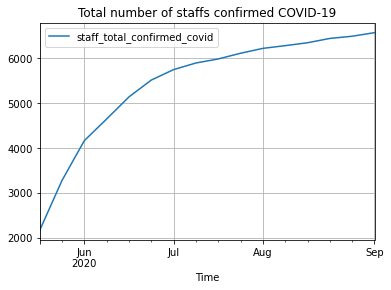

In [372]:
df["staff_total_confirmed_covid"] = df["staff_total_confirmed_covid"].fillna(0).astype(float)
total_confirmed_staff = df.pivot_table(values = "staff_total_confirmed_covid", index = "week_ending", aggfunc = "sum")
total_confirmed_staff.plot(title = "Total number of staffs confirmed COVID-19",
                     xlabel = "Time",
                     grid = True                
)

<AxesSubplot:title={'center':'Total number of residents and staff confirmed COVID-19'}, xlabel='Time'>

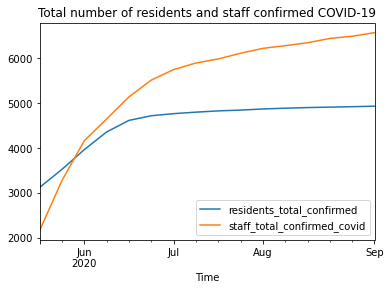

In [373]:
total_confirmed_resident.merge(total_confirmed_staff, how = "inner", on = "week_ending").plot(
    title = "Total number of residents and staff confirmed COVID-19",
    xlabel = "Time")

##### Although staffs in nursing homes are equipped with proper protections and medical supplies, they are still suffering hard from COVID-19. Probably they need better training or at least be more cautious.

# 4. Shortage of staff

## a. Nursing staff shortage

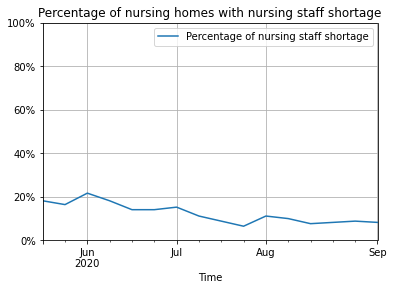

In [389]:
# Extract number of nursing homes with shortage of nursing staff
mask8 = df["shortage_of_nursing_staff"] == "Y"
nurse_shortage = df[mask8].pivot_table(
    values = "shortage_of_nursing_staff", 
    index = "week_ending", 
    aggfunc = "count"
)

# Convert it into percentages
nurse_shortage["Percentage of nursing staff shortage"] = nurse_shortage["shortage_of_nursing_staff"]/171
# Plot
nurse_shortage.plot(y = ["Percentage of nursing staff shortage"],
               xlabel = "Time",
               ylim = (0, 1),
               title = "Percentage of nursing homes with nursing staff shortage",
               grid = True
).yaxis.set_major_formatter(ticker.PercentFormatter(xmax = 1))

## b. Clinical staff shortage

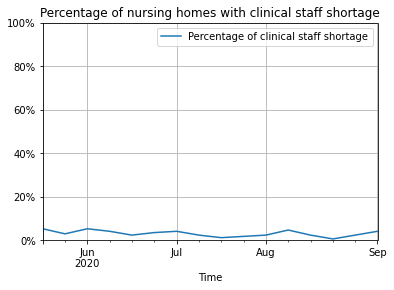

In [390]:
# Extract number of nursing homes with shortage of clinical staff
mask9 = df["shortage_of_clinical_staff"] == "Y"
clinical_shortage = df[mask9].pivot_table(
    values = "shortage_of_clinical_staff", 
    index = "week_ending", 
    aggfunc = "count"
)

# Convert it into percentages
clinical_shortage["Percentage of clinical staff shortage"] = clinical_shortage["shortage_of_clinical_staff"]/171
# Plot
clinical_shortage.plot(y = ["Percentage of clinical staff shortage"],
               xlabel = "Time",
               ylim = (0, 1),
               title = "Percentage of nursing homes with clinical staff shortage",
               grid = True
).yaxis.set_major_formatter(ticker.PercentFormatter(xmax = 1))

## c. Shortage of Aides

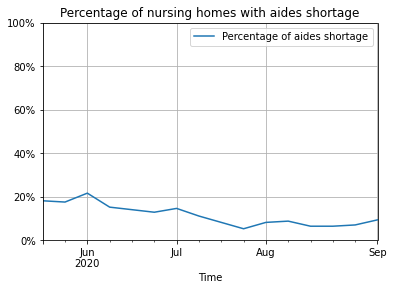

In [391]:
# Extract number of nursing homes with shortage of aides
mask10 = df["shortage_of_aides"] == "Y"
aides_shortage = df[mask10].pivot_table(
    values = "shortage_of_aides", 
    index = "week_ending", 
    aggfunc = "count"
)

# Convert it into percentages
aides_shortage["Percentage of aides shortage"] = aides_shortage["shortage_of_aides"]/171
# Plot
aides_shortage.plot(y = ["Percentage of aides shortage"],
               xlabel = "Time",
               ylim = (0, 1),
               title = "Percentage of nursing homes with aides shortage",
               grid = True
).yaxis.set_major_formatter(ticker.PercentFormatter(xmax = 1))

## d. Shortage of other staff

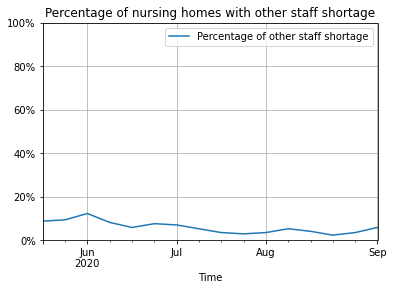

In [392]:
# Extract number of nursing homes with shortage of aides
mask11 = df["shortage_of_other_staff"] == "Y"
other_shortage = df[mask11].pivot_table(
    values = "shortage_of_other_staff", 
    index = "week_ending", 
    aggfunc = "count"
)

# Convert it into percentages
other_shortage["Percentage of other staff shortage"] = other_shortage["shortage_of_other_staff"]/171
# Plot
other_shortage.plot(y = ["Percentage of other staff shortage"],
               xlabel = "Time",
               ylim = (0, 1),
               title = "Percentage of nursing homes with other staff shortage",
               grid = True
).yaxis.set_major_formatter(ticker.PercentFormatter(xmax = 1))

# 5. Resident confirmed COVID-19 per 1000 residents

In [402]:
df["total_resident_confirmed_covid_19_cases_per_1_000_residents"] = df["total_resident_confirmed_covid_19_cases_per_1_000_residents"].fillna(0).astype(float)

In [405]:
def func1(x):
    if 0 <= x < 50:
        return "0~50"
    if 50 <= x < 100:
        return "50~100"
    if 100 <= x < 200:
        return "100~200"
    if 200 <= x < 300:
        return "200~300"
    else:
        return ">300"


<AxesSubplot:title={'center':'Infection per 1000 residents in nursing homes in NYC'}, ylabel=' '>

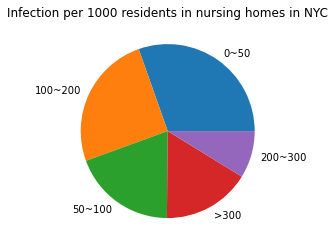

In [448]:
df0906 = df[df["week_ending"] == "2020-09-06"]
df0906 = df0906["total_resident_confirmed_covid_19_cases_per_1_000_residents"].apply(func1).to_frame()
per_1000 = df0906["total_resident_confirmed_covid_19_cases_per_1_000_residents"].value_counts()
per_1000.rename(" ", inplace = True)
per_1000.plot(title = "Infection per 1000 residents in nursing homes in NYC",
              kind = "pie")

### Something worth noticing: Residents' accessibility to testing

<AxesSubplot:title={'center':'Nursing homes in which resident have access to testing'}, xlabel='Time'>

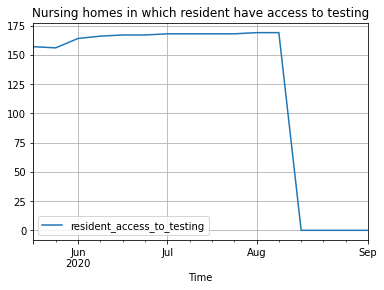

In [350]:
total_confirmed = df.pivot_table(values = "resident_access_to_testing", index = "week_ending", aggfunc = "count")
total_confirmed.plot(title = "Nursing homes in which resident have access to testing",
                     xlabel = "Time",
                     grid = True                
)

<AxesSubplot:title={'center':'Able to test all residents in next 7 days'}, xlabel='Time'>

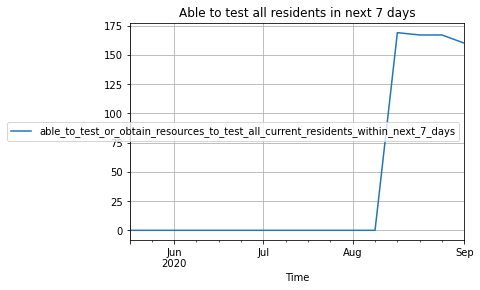

In [351]:
total_confirmed = df.pivot_table(values = "able_to_test_or_obtain_resources_to_test_all_current_residents_within_next_7_days", index = "week_ending", aggfunc = "count")
total_confirmed.plot(title = "Able to test all residents in next 7 days",
                     xlabel = "Time",
                     grid = True                
)

##### My guess: They adjusted the way they record data on the second week of August. It is smart move because the new way is more scientific and insightful.